![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Advanced Soil Mechanics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics

# MCC implementation tests

In [3]:
#HIDDEN
import numpy as np
import matplotlib.pyplot as plt #plotting
import seaborn as sns
import os
import mtest
import tfel.math
import pandas as pd
import tqdm

In [4]:
import plot_settings

In [5]:
%run plot_settings.py

/home/mok/MechanicsTrainingCourse2020/MFront/plot_settings.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [6]:
%run stress_path_defs.ipynb

In [7]:
#HIDDEN
build_release = 'mfront --obuild --interface=generic SemiImplicitModifiedCamClayInc_OpenGeoSys2023.mfront'
#os.system(build_release)

In [8]:
nu = 0.25  # Poisson ratio
E = 50.0e6  # Young's modulus in Pa
la = 7.7e-2  # slope of the virgin consolidation line
ka = 6.6e-3  # slope of the swelling line
M = 1.2  # slope of the critical state line (CSL)
v0 = 1.788  # initial volume ratio
phi0 = 1 - 1 / v0  # Initial porosity
pc0 = 800.0e3  # Initial pre-consolidation pressure in Pa
pamb = 1.0  # Ambient pressure in Pa

In [9]:
times = np.linspace(0,4.75,700)
f = lambda t: 0.02*np.sqrt(t)*(1+np.sin(2*np.pi*t)*0.25)
eax = {t: f(t) for t in times}

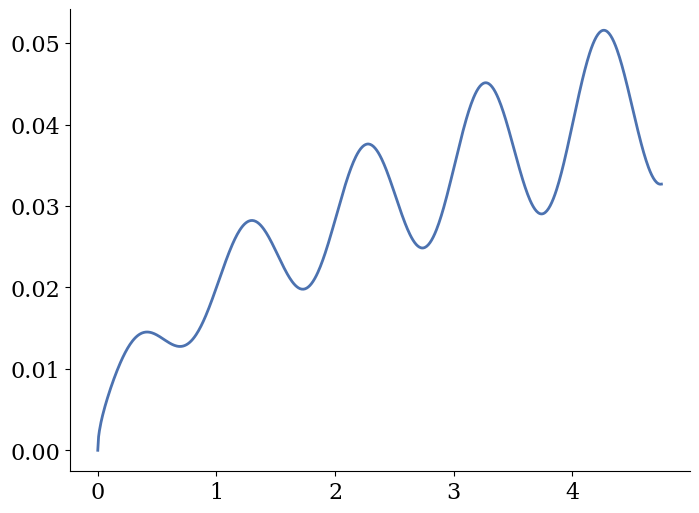

In [10]:
plt.plot(times,f(times))

In [11]:
%run stress_path_defs.ipynb
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr = \
MCC_triax_test_driven(E,nu,la,ka,M,v0,phi0,pc0,pamb,100e3,eax,times)

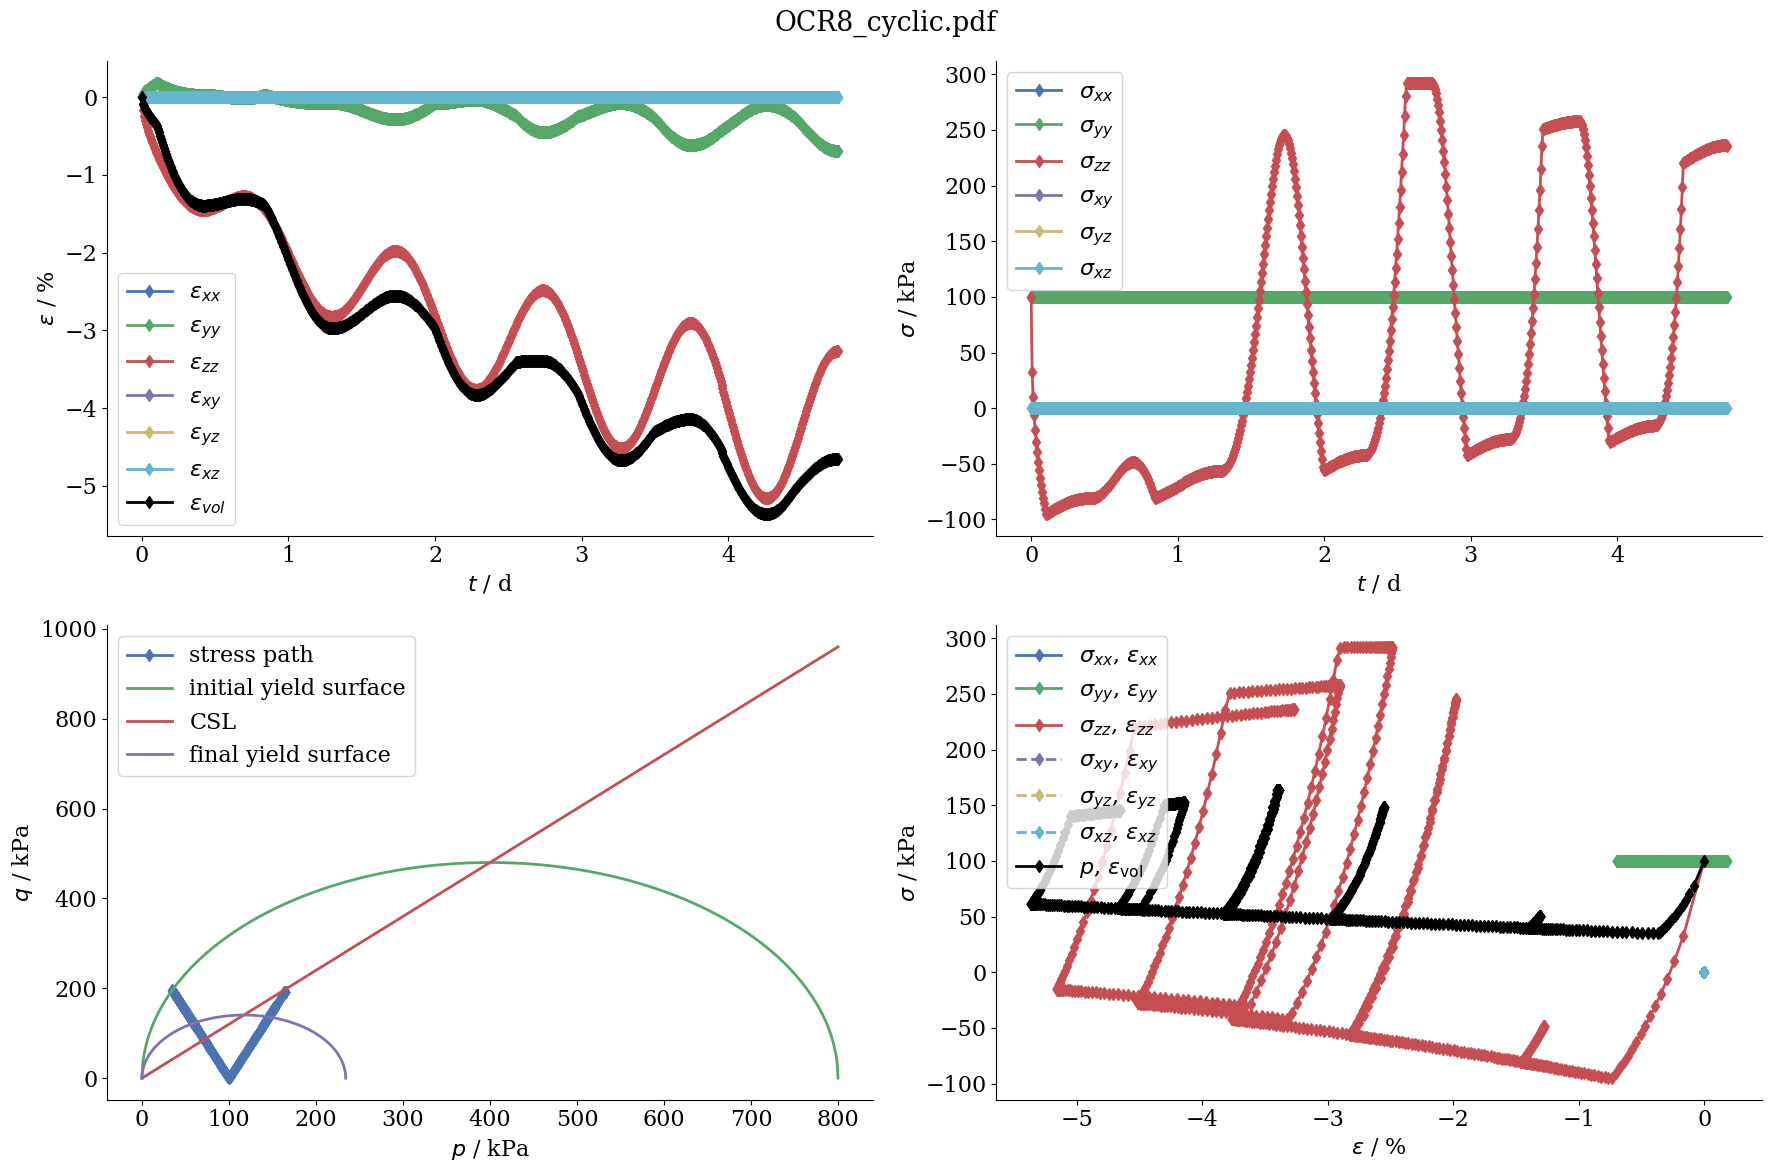

In [12]:
plot_results_MCC(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr,M,'OCR8_cyclic.pdf')

In [13]:
sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr = \
MCC_triax_test_driven(E,nu,la,ka,M,v0,phi0,pc0,pamb,400e3,eax,times)

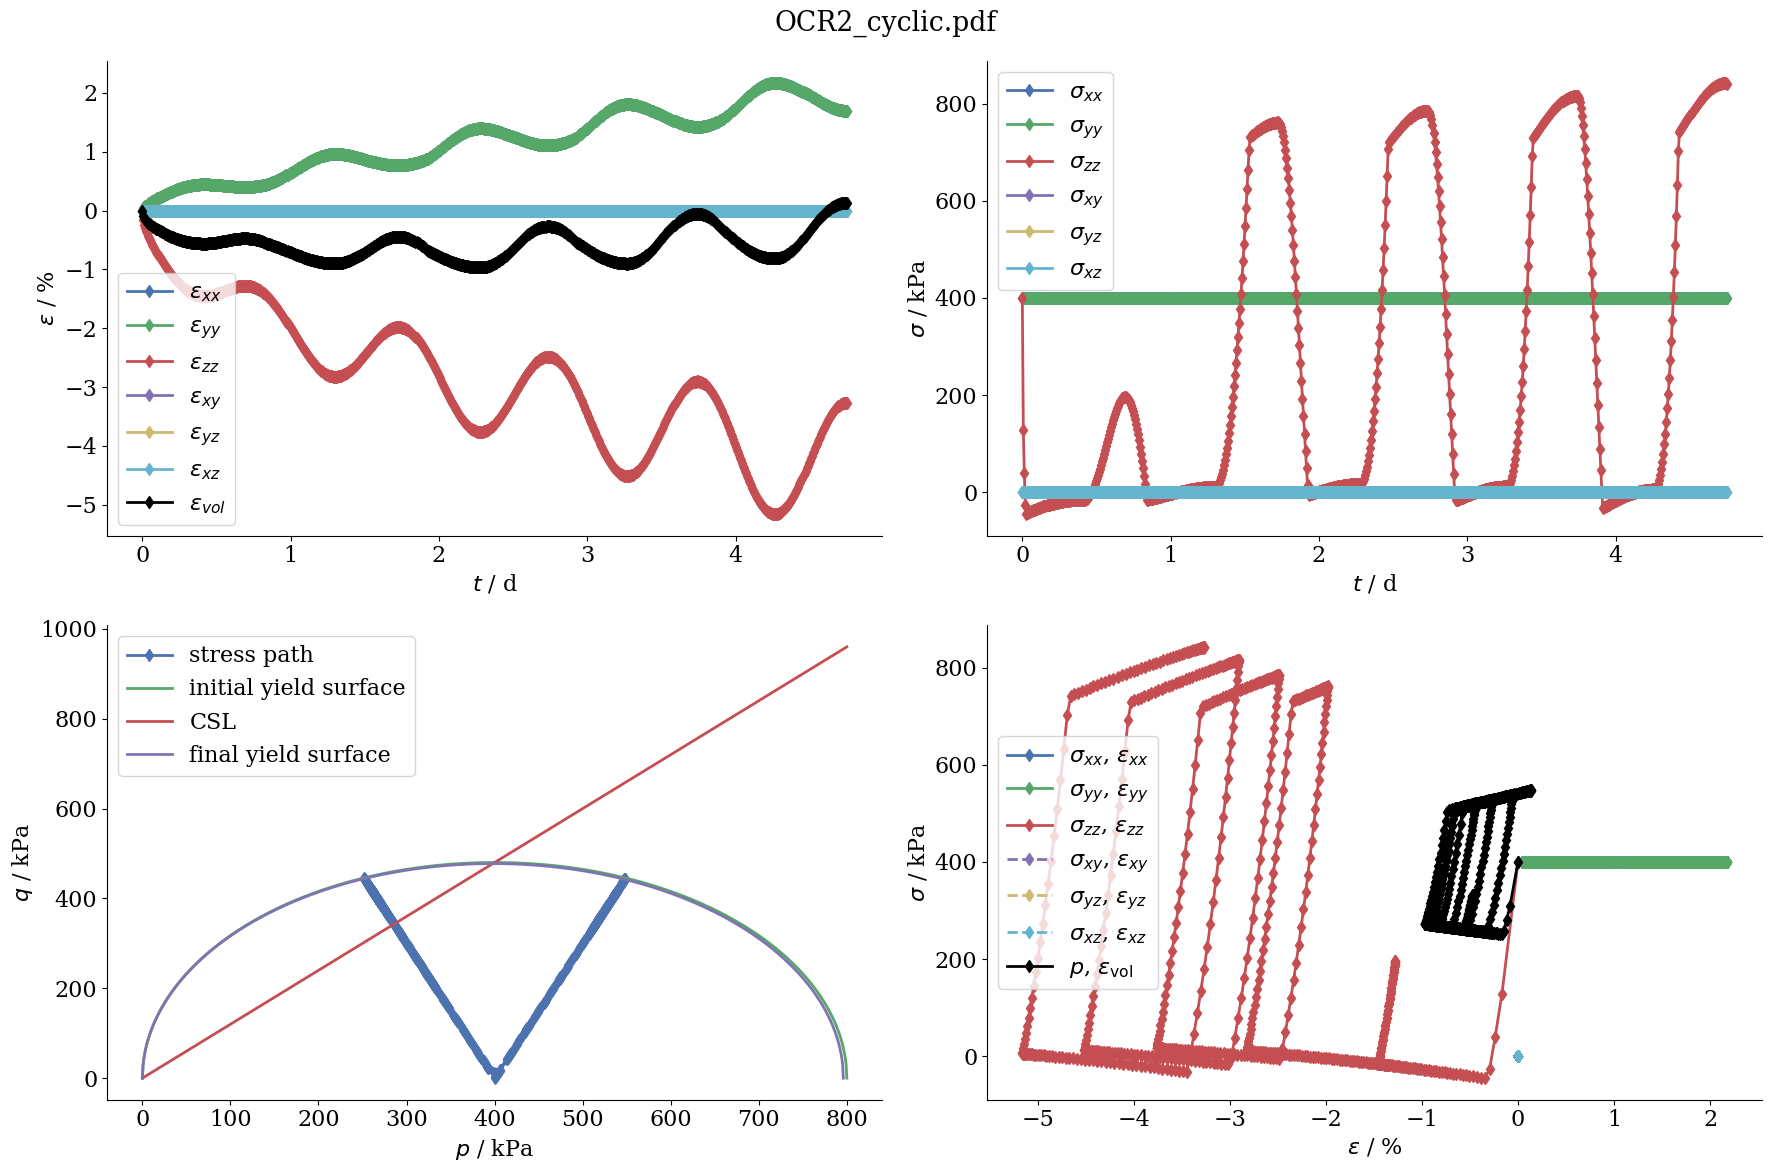

In [14]:
plot_results_MCC(sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr,M,'OCR2_cyclic.pdf')

In [25]:
set_of_frames = []
las = np.arange(0.06,0.22,0.04)
v0s = np.arange(1.2,2,0.1)
pcons = np.arange(200.e3,2000.e3,200e3)
OCRs = np.arange(1.,5.,1)
Ms = np.arange(0.8,1.2,0.1)
total_runs = len(las)*len(v0s)*len(pcons)*len(OCRs)*len(Ms)
print('%i Total Sims' %total_runs)

4608 Total Sims


In [26]:
with tqdm.tqdm(total=total_runs) as pbar:
    for la in las:
        for v0 in v0s:
            for pcon in pcons:
                for OCR in OCRs:
                    for M in Ms:
                        sig_xx, eps_xx, sig_yy, eps_yy, sig_zz, eps_zz, tau_xy, eps_xy, tau_xz, eps_xz, tau_yz, eps_yz, pc, vr = \
                                    MCC_triax_test_driven(E,nu,la,la/10,M,v0,phi0,OCR*pcon,pamb,pcon,eax,times)
                        p_eff = (sig_xx + sig_yy + sig_zz)/3
                        q = compute_q(sig_xx,sig_yy,sig_zz,tau_xy,tau_yz,tau_xz)
                        e_vol = eps_xx + eps_yy + eps_zz
                        results = pd.DataFrame({
                            'VirginConsolidationLineSlope': la,
                            'InitialVolumeRatio': v0,
                            'ConfiningPressure_kPa': pcon,
                            'OCR': OCR,
                            'CriticalStateLineSlope': M,
                            'AxialStrainHistory': f(times),
                            'HydrostaticPressure': p_eff,
                            'DeviatoricStress': q,
                            'VolumeStrain': e_vol
                        })
                        set_of_frames.append(results)
                        pbar.update()

 23%|████████████████████▋                                                                      | 1046/4608 [01:39<07:34,  7.83it/s]













 Negative plastic increment! 


 23%|█████████████████████▎                                                                     | 1077/4608 [01:42<07:01,  8.38it/s]



 Negative plastic increment! 


 24%|█████████████████████▌                                                                     | 1094/4608 [01:44<06:43,  8.71it/s]


 Negative plastic increment! 


 24%|█████████████████████▉                                                                     | 1110/4608 [01:46<07:05,  8.21it/s]


 Negative plastic increment! 


 25%|██████████████████████▌                                                                    | 1141/4608 [01:50<06:32,  8.83it/s]



 Negative plastic increment! 


100%|███████████████████████████████████████████████████████████████████████████████████████████| 4608/4608 [08:07<00:00,  9.46it/s]


In [27]:
# Write each data frame to a separate CSV file
for i, df in enumerate(set_of_frames):
    df.to_csv(f'Results_Reza/MCC_cyclic_{i}.csv', index=False)

In [29]:
# List of CSV files
csv_files = [f for f in os.listdir('Results_Reza/') if f.endswith('.csv')]

# List to store DataFrames
df_list = []

# Loop through the list of files
for file in csv_files:
    df = pd.read_csv('Results_Reza/'+file)
    df_list.append(df)